In [1]:
import uproot
import numpy as np
import awkward as ak
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
data = pickle.load( open( "data_combined.pkl", "rb" ) )
X_train, y_train, X_val, y_val, X_test, y_test = data

In [3]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder, self).__init__()
        self.pre_norm_Q = nn.LayerNorm(embed_dim)
        self.pre_norm_K = nn.LayerNorm(embed_dim)
        self.pre_norm_V = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.post_norm = nn.LayerNorm(embed_dim)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        Query = self.pre_norm_Q(Query)
        Key = self.pre_norm_K(Key)
        Value = self.pre_norm_V(Value)
        context, weights = self.attention(Query, Key, Value)
        context = self.post_norm(context)
        latent = Query + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return latent, weights

class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 256
        self.num_heads = 4
        self.num_jet_feats = 4
        self.num_trk_feats = 6
        
        self.jet_initializer = nn.Linear(self.num_jet_feats, self.embed_dim)
        self.jet_trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
            
        # Track Encoder Stack
        self.trk_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.trk_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.trk_encoder3 = Encoder(self.embed_dim, self.num_heads)
        self.jet_postprocess = nn.Linear(self.embed_dim*2, self.embed_dim)
        
        # All Track Encoder Stack
        self.all_trk_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.all_trk_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.all_trk_encoder3 = Encoder(self.embed_dim, self.num_heads)
        
        # Cross Encoder Stack
        self.cross_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.cross_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.cross_encoder3 = Encoder(self.embed_dim, self.num_heads)
        
        # Jet Encoder Stack
        self.jet_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.jet_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.jet_encoder3 = Encoder(self.embed_dim, self.num_heads)

        # Regression Task
        self.regression = nn.Linear(self.embed_dim, 1)
        
    def forward(self, jets, jet_trks, trks):
        # Feature preprocessing layers
        jet_init = F.relu(self.jet_initializer(jets))
        jet_trk_init = F.relu(self.jet_trk_initializer(jet_trks))
        trk_init = F.relu(self.trk_initializer(trks))
        
        # Calculate aggregated tracks using attention
        jet_trk_embedding, trk_weights = self.trk_encoder1(jet_trk_init, jet_trk_init, jet_trk_init)
        jet_trk_embedding, trk_weights = self.trk_encoder2(jet_trk_embedding, jet_trk_embedding, jet_trk_embedding)
        jet_trk_embedding, trk_weights = self.trk_encoder3(jet_trk_embedding, jet_trk_embedding, jet_trk_embedding)
        
        # Generate meaningful jet_embedding using info from trk_aggregated  
        jet_trk_aggregated = jet_trk_embedding.sum(dim=1)
        jet_embedding = torch.cat((jet_init, jet_trk_aggregated),1)
        jet_embedding = F.relu(self.jet_postprocess(jet_embedding))
        
        # All Track Attention
        all_trk_embedding, all_trk_weights = self.all_trk_encoder1(trk_init, trk_init, trk_init)
        all_trk_embedding, all_trk_weights = self.all_trk_encoder2(all_trk_embedding, all_trk_embedding, all_trk_embedding)
        all_trk_embedding, all_trk_weights = self.all_trk_encoder3(all_trk_embedding, all_trk_embedding, all_trk_embedding)

        # Cross Attention
        jet_embedding, cross_weights = self.cross_encoder1(jet_embedding, all_trk_embedding, all_trk_embedding)
        jet_embedding, cross_weights = self.cross_encoder2(jet_embedding, all_trk_embedding, all_trk_embedding)
        jet_embedding, cross_weights = self.cross_encoder3(jet_embedding, all_trk_embedding, all_trk_embedding)
        
        # Update embeddings of jets in the contex of entire event
        jet_embedding, jet_weights = self.jet_encoder1(jet_embedding, jet_embedding, jet_embedding)
        jet_embedding, jet_weights = self.jet_encoder2(jet_embedding, jet_embedding, jet_embedding)
        jet_embedding, jet_weights = self.jet_encoder3(jet_embedding, jet_embedding, jet_embedding)
        
        # Get output
        output = F.sigmoid(self.regression(jet_embedding))
        
        return output, jet_weights, trk_weights, cross_weights

In [4]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print()

GPU Available:  True
cuda:0



In [5]:
model = torch.load("../models/results/PUFNN.torch")

PUFrANN = model.to(device)

/tmp/ipykernel_3140065/4093707428.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("../models/results/PUFNN.torch")


In [6]:
#%%time
def calc_pred(X, y):
    # Process data
    jet = []
    label = []
    pufr = []
    for event in range(len(X)):
        if event%5 == 0:
            print("\tEvaluating PUFR Prediction: ", event, " / ", len(X), end="\r")
        jets = X[event][0][:,0:4]
        jet_trks = X[event][1]
        trks = X[event][2]
        pufr_pred = PUFrANN(jets.to(device),jet_trks.to(device),trks.to(device))[0].detach().cpu()
        jets = torch.cat((jets,pufr_pred),dim=1)
        jet.append(jets.tolist())
        label.append(y[event])
        pufr.append(X[event][0][:,-1].reshape(-1,1).tolist())
    print("\tEvaluating PUFR Prediction: ", len(X), " / ", len(X))
    
    # Convert to Awkward Array
    jet = ak.Array(jet)
    label = ak.Array(label)
    pufr = ak.Array(pufr)
          
    # Calculate baseline and truth datasets
    dataset = jet
    baseline = jet[:,:,0:4]
    truth = ak.concatenate([baseline,pufr], axis=2)
                     
    return dataset, baseline, truth, label
    
print("Processing training dataset...")
X_train_pufr, X_train_baseline, X_train_truth, y_train = calc_pred(X_train, y_train)
print("Processing validation dataset...")
X_val_pufr, X_val_baseline, X_val_truth, y_val = calc_pred(X_val, y_val) 
print("Processing testing dataset...")
X_test_pufr, X_test_baseline, X_test_truth, y_test = calc_pred(X_test, y_test) 

Processing training dataset...
	Evaluating PUFR Prediction:  14000  /  14000
Processing validation dataset...
	Evaluating PUFR Prediction:  1000  /  1000
Processing testing dataset...
	Evaluating PUFR Prediction:  5000  /  5000


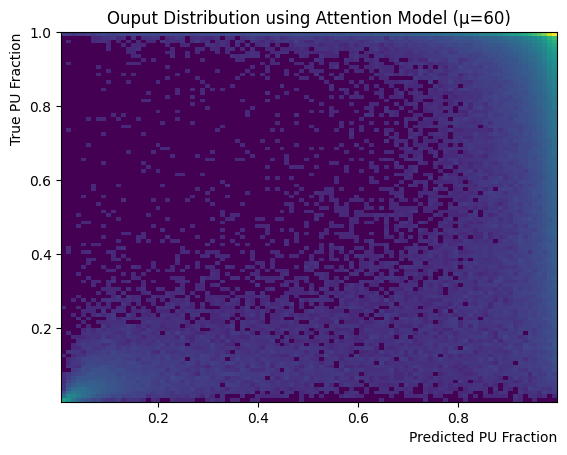

In [7]:
plt.title("Ouput Distribution using Attention Model (\u03BC=60)")
pufr_pred = ak.flatten(X_test_pufr[:,:,-1])
pufr_truth = ak.flatten(X_test_truth[:,:,-1])
plt.hist2d(np.array(pufr_pred),np.array(pufr_truth),bins=100,norm=mcolors.PowerNorm(0.2))
plt.xlabel('Predicted PU Fraction',loc='right')
plt.ylabel('True PU Fraction',loc='top')
plt.show()

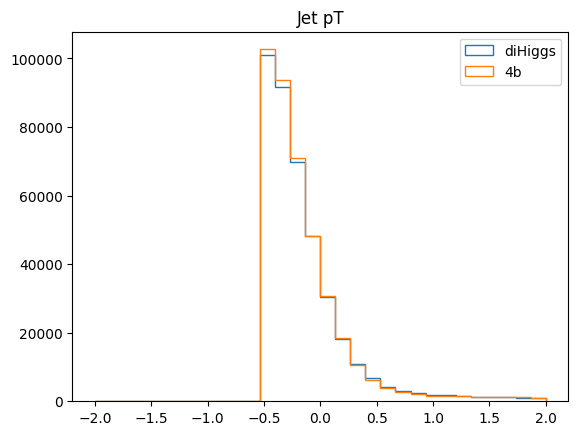

Mean:  0.00021520226741593876
STD:  1.002713280346126


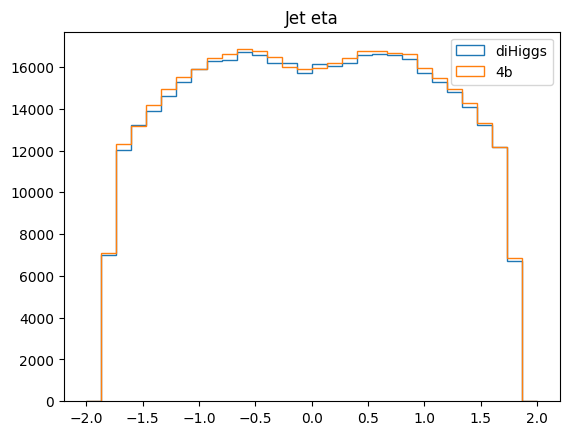

Mean:  6.7270226535777e-05
STD:  1.0001547898019898


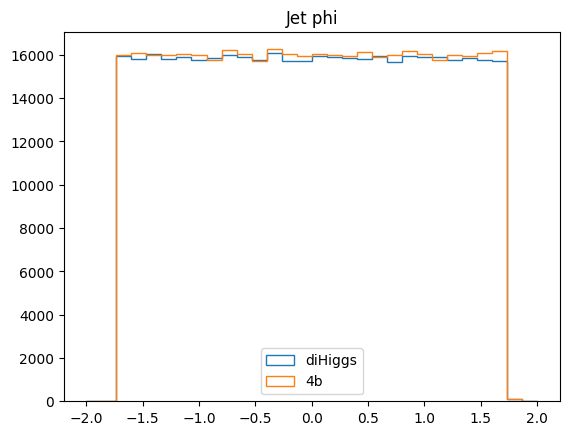

Mean:  -0.0004456471697338269
STD:  1.000967967427883


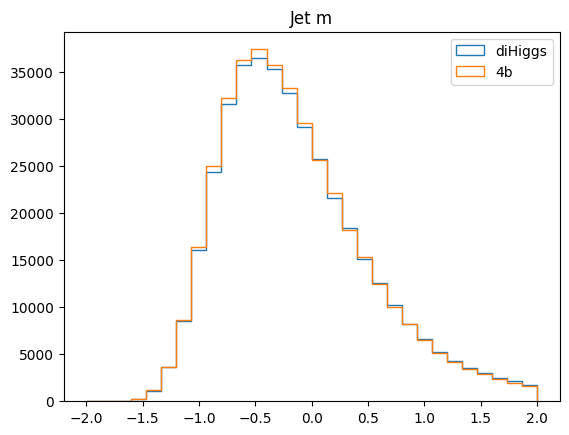

Mean:  0.00020824489988073127
STD:  1.0011825690205358


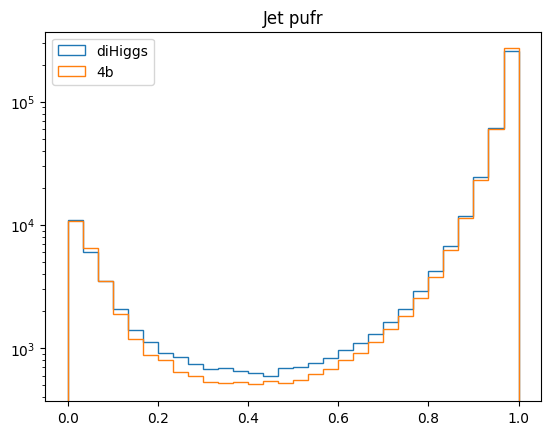

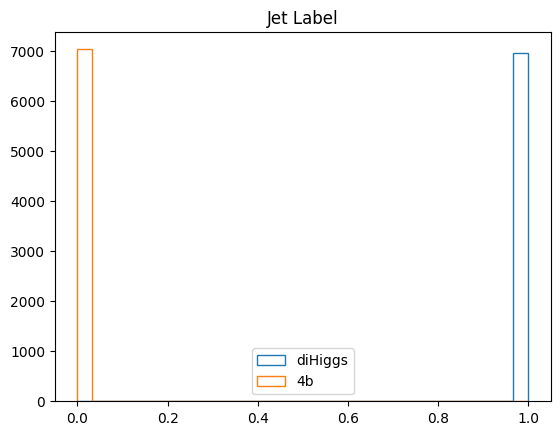

In [8]:
sig = y_train==1

plt.title("Jet pT")
plt.hist(ak.ravel(X_train_pufr[sig][:,:,0]),histtype='step',bins=30,label='diHiggs',range=(-2,2))
plt.hist(ak.ravel(X_train_pufr[~sig][:,:,0]),histtype='step',bins=30,label='4b',range=(-2,2))
plt.legend()
plt.show()
print("Mean: ", ak.mean(X_train_pufr[:,:,0]))
print("STD: ", ak.std(X_train_pufr[:,:,0]))

plt.title("Jet eta")
plt.hist(ak.ravel(X_train_pufr[sig][:,:,1]),histtype='step',bins=30,label='diHiggs',range=(-2,2))
plt.hist(ak.ravel(X_train_pufr[~sig][:,:,1]),histtype='step',bins=30,label='4b',range=(-2,2))
plt.legend()
plt.show()
print("Mean: ", ak.mean(X_train_pufr[:,:,1]))
print("STD: ", ak.std(X_train_pufr[:,:,1]))

plt.title("Jet phi")
plt.hist(ak.ravel(X_train_pufr[sig][:,:,2]),histtype='step',bins=30,label='diHiggs',range=(-2,2))
plt.hist(ak.ravel(X_train_pufr[~sig][:,:,2]),histtype='step',bins=30,label='4b',range=(-2,2))
plt.legend()
plt.show()
print("Mean: ", ak.mean(X_train_pufr[:,:,2]))
print("STD: ", ak.std(X_train_pufr[:,:,2]))

plt.title("Jet m")
plt.hist(ak.ravel(X_train_pufr[sig][:,:,3]),histtype='step',bins=30,label='diHiggs',range=(-2,2))
plt.hist(ak.ravel(X_train_pufr[~sig][:,:,3]),histtype='step',bins=30,label='4b',range=(-2,2))
plt.legend()
plt.show()
print("Mean: ", ak.mean(X_train_pufr[:,:,3]))
print("STD: ", ak.std(X_train_pufr[:,:,3]))

plt.title("Jet pufr")
plt.hist(ak.ravel(X_train_pufr[sig][:,:,4]),histtype='step',bins=30,label='diHiggs',range=(0,1))
plt.hist(ak.ravel(X_train_pufr[~sig][:,:,4]),histtype='step',bins=30,label='4b',range=(0,1))
plt.legend()
plt.yscale('log')
plt.show()

plt.title("Jet Label")
plt.hist(ak.ravel(y_train[sig]),histtype='step',bins=30,label='diHiggs',range=(0,1))
plt.hist(ak.ravel(y_train[~sig]),histtype='step',bins=30,label='4b',range=(0,1))
plt.legend()
plt.show()

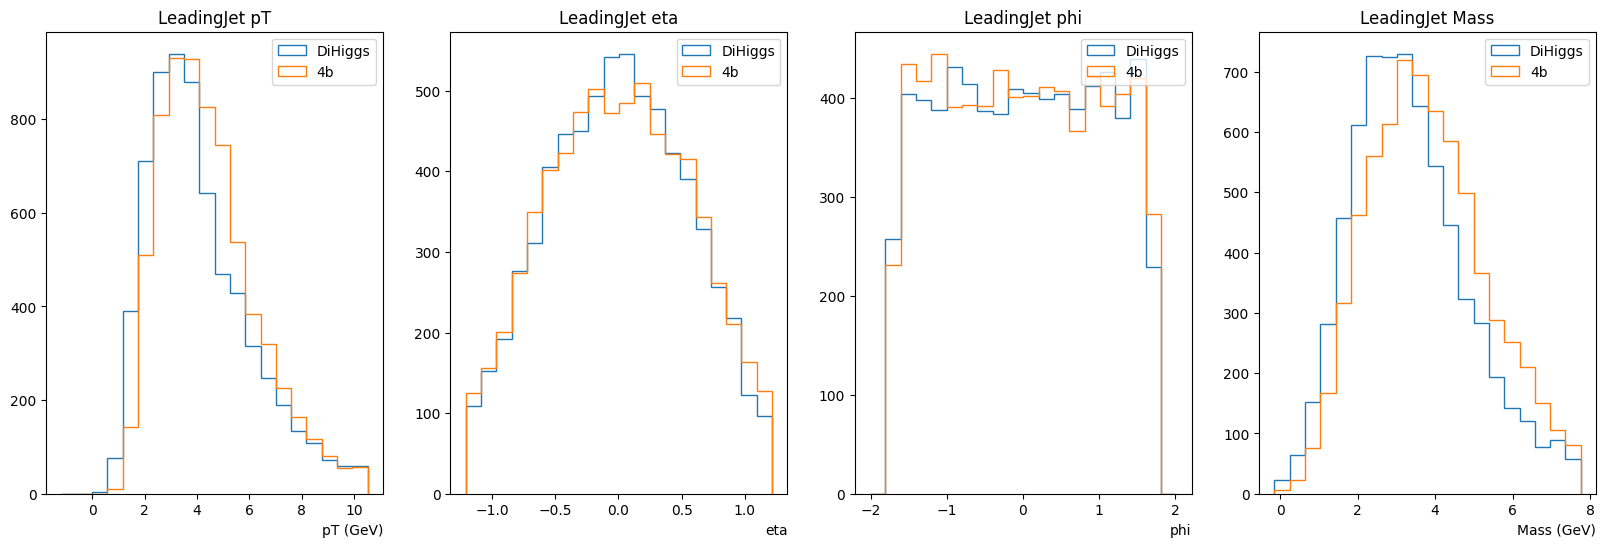

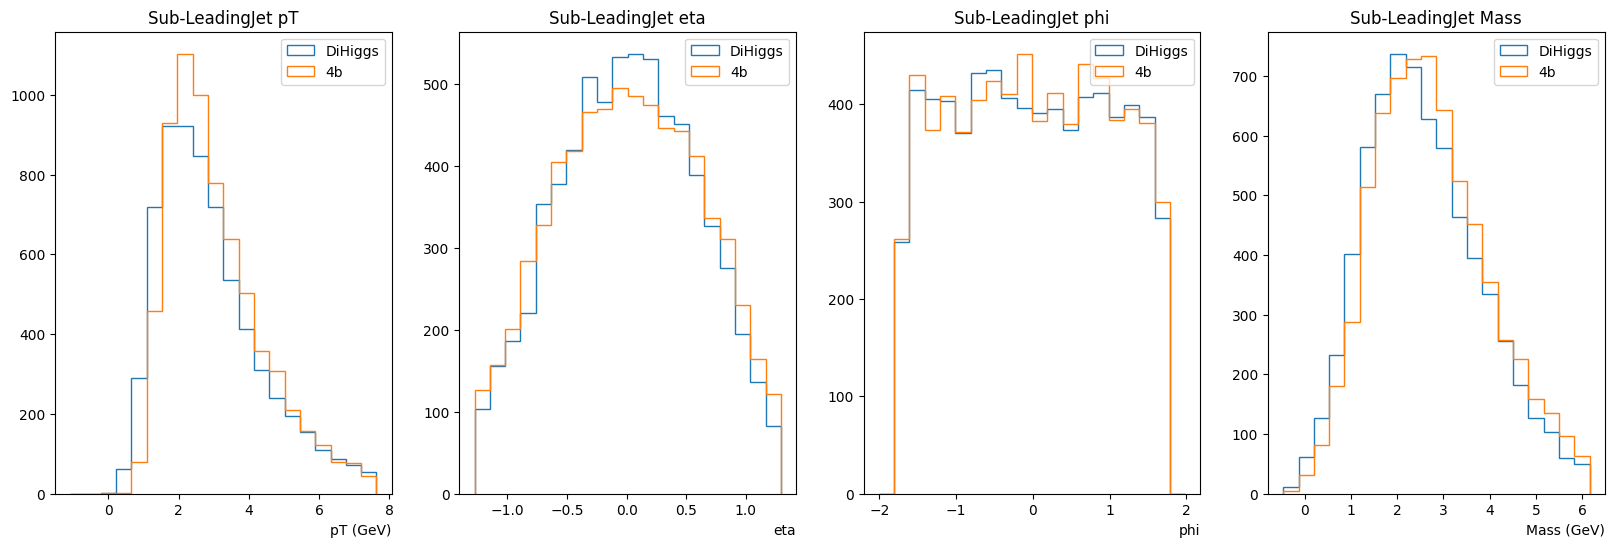

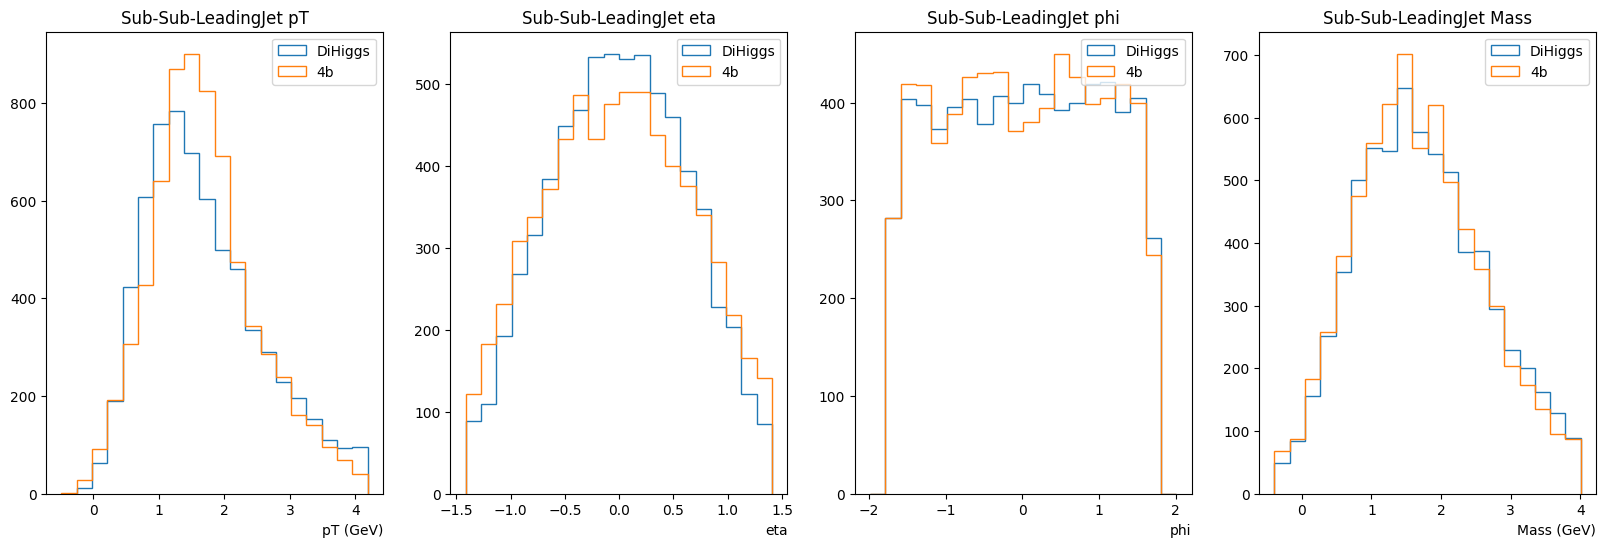

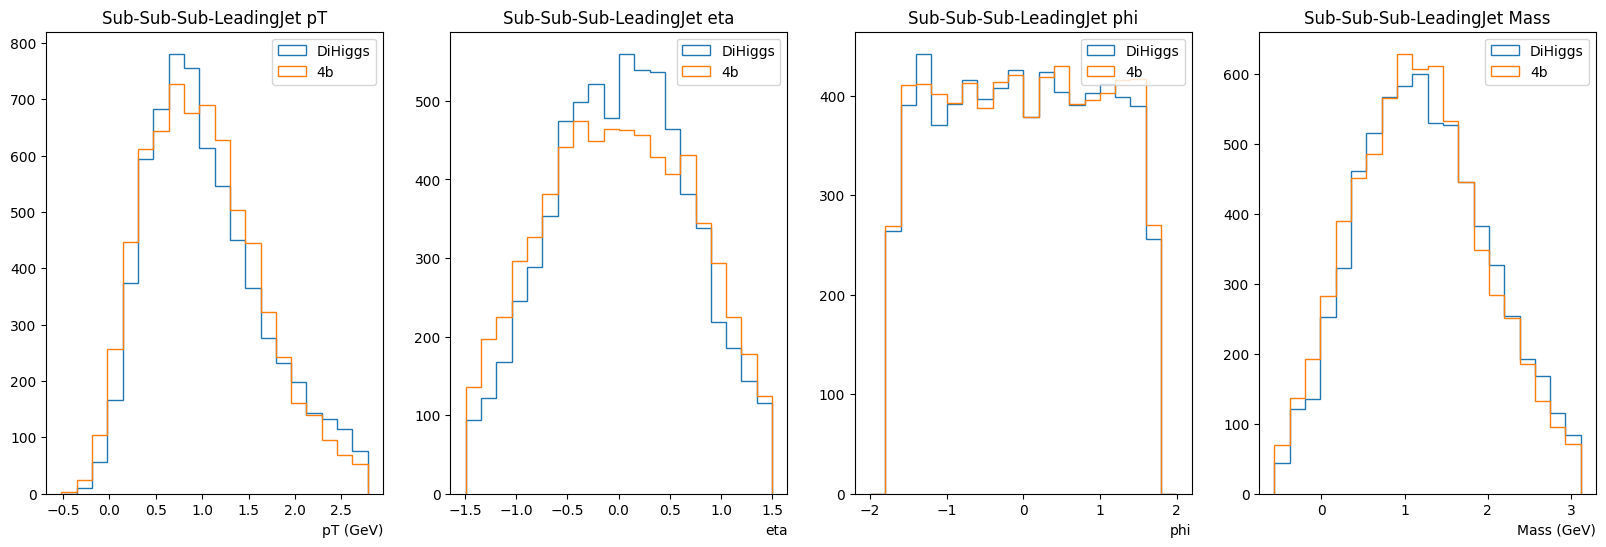

In [9]:
sig = y_train==1
bkg = ~sig
var_list = ['Leading','Sub-Leading','Sub-Sub-Leading','Sub-Sub-Sub-Leading']
for i, name in enumerate(var_list):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

    ax1.set_title(name+'Jet pT')
    mini=ak.mean(X_train_pufr[:,i,0])-2*ak.std(X_train_pufr[:,i,0])
    maxi=ak.mean(X_train_pufr[:,i,0])+2*ak.std(X_train_pufr[:,i,0])
    ax1.hist(X_train_pufr[:,i,0][sig],histtype='step',label='DiHiggs',bins=20,range=(mini,maxi))
    ax1.hist(X_train_pufr[:,i,0][bkg],histtype='step',label='4b',bins=20,range=(mini,maxi))
    ax1.set_xlabel('pT (GeV)',loc='right')
    ax1.legend(loc='upper right')

    ax2.set_title(name+'Jet eta')
    mini=ak.mean(X_train_pufr[:,i,1])-2*ak.std(X_train_pufr[:,i,1])
    maxi=ak.mean(X_train_pufr[:,i,1])+2*ak.std(X_train_pufr[:,i,1])
    ax2.hist(X_train_pufr[:,i,1][sig],histtype='step',label='DiHiggs',bins=20,range=(mini,maxi))
    ax2.hist(X_train_pufr[:,i,1][bkg],histtype='step',label='4b',bins=20,range=(mini,maxi))
    ax2.set_xlabel('eta',loc='right')
    ax2.legend(loc='upper right')


    ax3.set_title(name+'Jet phi')
    mini=ak.mean(X_train_pufr[:,i,2])-2*ak.std(X_train_pufr[:,i,2])
    maxi=ak.mean(X_train_pufr[:,i,2])+2*ak.std(X_train_pufr[:,i,2])
    ax3.hist(X_train_pufr[:,i,2][sig],histtype='step',label='DiHiggs',bins=20,range=(mini,maxi))
    ax3.hist(X_train_pufr[:,i,2][bkg],histtype='step',label='4b',bins=20,range=(mini,maxi))
    ax3.set_xlabel('phi',loc='right')
    ax3.legend(loc='upper right')

    ax4.set_title(name+'Jet Mass')
    mini=ak.mean(X_train_pufr[:,i,3])-2*ak.std(X_train_pufr[:,i,3])
    maxi=ak.mean(X_train_pufr[:,i,3])+2*ak.std(X_train_pufr[:,i,3])
    ax4.hist(X_train_pufr[:,i,3][sig],histtype='step',label='DiHiggs',bins=20,range=(mini,maxi))
    ax4.hist(X_train_pufr[:,i,3][bkg],histtype='step',label='4b',bins=20,range=(mini,maxi))
    ax4.set_xlabel('Mass (GeV)',loc='right')
    ax4.legend(loc='upper right')
    plt.show()

In [10]:
# Convert to torch.Tensor()
X_train_pufr = torch.nested.nested_tensor(ak.to_list(X_train_pufr))
X_train_truth = torch.nested.nested_tensor(ak.to_list(X_train_truth))
X_train_baseline = torch.nested.nested_tensor(ak.to_list(X_train_baseline))
y_train = torch.Tensor(ak.to_list(y_train)).reshape(-1,1)

X_val_pufr = torch.nested.nested_tensor(ak.to_list(X_val_pufr))
X_val_truth = torch.nested.nested_tensor(ak.to_list(X_val_truth))
X_val_baseline = torch.nested.nested_tensor(ak.to_list(X_val_baseline))
y_val = torch.Tensor(ak.to_list(y_val)).reshape(-1,1)

X_test_pufr = torch.nested.nested_tensor(ak.to_list(X_test_pufr))
X_test_truth = torch.nested.nested_tensor(ak.to_list(X_test_truth))
X_test_baseline = torch.nested.nested_tensor(ak.to_list(X_test_baseline))
y_test = torch.Tensor(ak.to_list(y_test)).reshape(-1,1)

/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/nested/__init__.py:220: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


In [11]:
class Encoder2(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder2, self).__init__()
        self.pre_norm_Q = nn.LayerNorm(embed_dim)
        self.pre_norm_K = nn.LayerNorm(embed_dim)
        self.pre_norm_V = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.post_norm = nn.LayerNorm(embed_dim)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        #Query = self.pre_norm_Q(Query)
        #Key = self.pre_norm_K(Key)
        #Value = self.pre_norm_V(Value)
        context, weights = self.attention(Query, Key, Value)
        #context = self.post_norm(context)
        latent = Query + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return latent, weights

class Model2(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Model2, self).__init__()        
        self.jet_preprocess = nn.Linear(in_feats,hidden_feats)
        self.encoder1 = Encoder2(hidden_feats,num_heads=8)
        self.encoder2 = Encoder2(hidden_feats,num_heads=8)
        self.encoder3 = Encoder2(hidden_feats,num_heads=8)
        self.encoder4 = Encoder2(hidden_feats,num_heads=8)
        self.encoder5 = Encoder2(hidden_feats,num_heads=8)

        self.jet_postprocess = nn.Linear(hidden_feats,hidden_feats)
        self.jet_classifier = nn.Linear(hidden_feats,out_feats)
    def forward(self, jet_feats):
        # Preprocess Jet Feats
        jet_embedding = F.gelu(self.jet_preprocess(jet_feats))
        
        # Attention Layer + Skip Connection + Post-Process
        jet_embedding, jet_weights = self.encoder1(jet_embedding,jet_embedding,jet_embedding)
        jet_embedding, jet_weights = self.encoder2(jet_embedding,jet_embedding,jet_embedding)
        jet_embedding, jet_weights = self.encoder3(jet_embedding,jet_embedding,jet_embedding)
        jet_embedding, jet_weights = self.encoder4(jet_embedding,jet_embedding,jet_embedding)
        jet_embedding, jet_weights = self.encoder5(jet_embedding,jet_embedding,jet_embedding)
      
        # Aggregate and Classify
        jet_aggregated = jet_embedding.sum(dim=0)
        jet_aggregated = F.gelu(self.jet_postprocess(jet_aggregated))
        output = F.sigmoid(self.jet_classifier(jet_aggregated))
        return output

In [12]:
def train(model, optimizer, data, epochs=20):
    X_train, y_train, X_val, y_val = data
        
    history = {'train_loss':[],'test_loss':[]}
   
    step_size=30
    gamma=0.1
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    for e in range(epochs):     
        cum_loss_train = []
        cum_loss_val = []
        num_train = X_train.size(0)
        model.train()
        for event in range(num_train):
            optimizer.zero_grad()
            output = model(X_train[event].to(device))
            loss = loss_fn(output, y_train[event].to(device))
            loss.backward()
            optimizer.step()
            cum_loss_train.append(loss.detach().cpu().numpy())
        
        num_val = X_val.size(0)
        model.eval()
        for event in range(num_val):
            y_pred = model(X_val[event].to(device))
            loss = loss_fn(y_pred,y_val[event].to(device))
            cum_loss_val.append(loss.detach().cpu().numpy())
            
        scheduler.step()

        history['train_loss'].append(np.mean(cum_loss_train))
        history['test_loss'].append(np.mean(cum_loss_val))

        if (e+1)%1==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(np.mean(cum_loss_train)),4),'\tVal Loss:',round(float(np.mean(cum_loss_val)),4))

        if (e+1)%step_size==0:
            print("\tReducing Step Size by ", gamma)
            
    return history

In [13]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


Training with Pred PUFR
Epoch: 1 	Train Loss: 0.7148 	Val Loss: 0.6948
Epoch: 2 	Train Loss: 0.684 	Val Loss: 0.679
Epoch: 3 	Train Loss: 0.6746 	Val Loss: 0.6683
Epoch: 4 	Train Loss: 0.666 	Val Loss: 0.6694
Epoch: 5 	Train Loss: 0.6631 	Val Loss: 0.6679
Epoch: 6 	Train Loss: 0.6671 	Val Loss: 0.6631
Epoch: 7 	Train Loss: 0.6596 	Val Loss: 0.664
Epoch: 8 	Train Loss: 0.6565 	Val Loss: 0.6598
Epoch: 9 	Train Loss: 0.6565 	Val Loss: 0.6565
Epoch: 10 	Train Loss: 0.6524 	Val Loss: 0.658
Epoch: 11 	Train Loss: 0.6511 	Val Loss: 0.6504
Epoch: 12 	Train Loss: 0.6486 	Val Loss: 0.6514
Epoch: 13 	Train Loss: 0.6473 	Val Loss: 0.6473
Epoch: 14 	Train Loss: 0.6451 	Val Loss: 0.6438
Epoch: 15 	Train Loss: 0.6414 	Val Loss: 0.6394
Epoch: 16 	Train Loss: 0.6374 	Val Loss: 0.6328
Epoch: 17 	Train Loss: 0.6329 	Val Loss: 0.6304
Epoch: 18 	Train Loss: 0.6287 	Val Loss: 0.6314
Epoch: 19 	Train Loss: 0.6236 	Val Loss: 0.6309
Epoch: 20 	Train Loss: 0.6227 	Val Loss: 0.6309
Epoch: 21 	Train Loss: 0.6174 

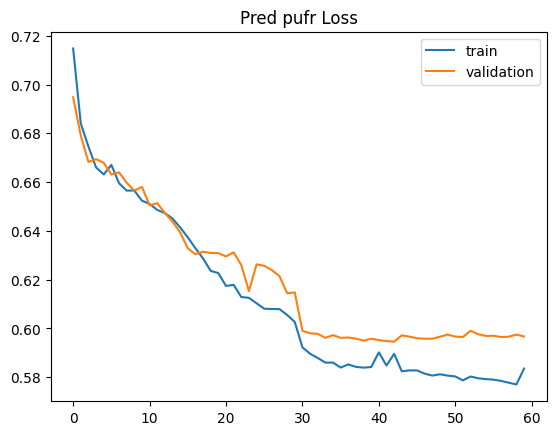


Training with Truth
Epoch: 1 	Train Loss: 0.7318 	Val Loss: 0.7049
Epoch: 2 	Train Loss: 0.6853 	Val Loss: 0.6862
Epoch: 3 	Train Loss: 0.6752 	Val Loss: 0.6747
Epoch: 4 	Train Loss: 0.6679 	Val Loss: 0.6629
Epoch: 5 	Train Loss: 0.6648 	Val Loss: 0.6663
Epoch: 6 	Train Loss: 0.6625 	Val Loss: 0.6666
Epoch: 7 	Train Loss: 0.661 	Val Loss: 0.6584
Epoch: 8 	Train Loss: 0.6597 	Val Loss: 0.6566
Epoch: 9 	Train Loss: 0.6565 	Val Loss: 0.655
Epoch: 10 	Train Loss: 0.6555 	Val Loss: 0.6543
Epoch: 11 	Train Loss: 0.653 	Val Loss: 0.6507
Epoch: 12 	Train Loss: 0.6516 	Val Loss: 0.65
Epoch: 13 	Train Loss: 0.6509 	Val Loss: 0.6457
Epoch: 14 	Train Loss: 0.6491 	Val Loss: 0.649
Epoch: 15 	Train Loss: 0.6475 	Val Loss: 0.6443
Epoch: 16 	Train Loss: 0.6459 	Val Loss: 0.639
Epoch: 17 	Train Loss: 0.6455 	Val Loss: 0.6398
Epoch: 18 	Train Loss: 0.6424 	Val Loss: 0.6392
Epoch: 19 	Train Loss: 0.6417 	Val Loss: 0.6362
Epoch: 20 	Train Loss: 0.6389 	Val Loss: 0.638
Epoch: 21 	Train Loss: 0.6357 	Val L

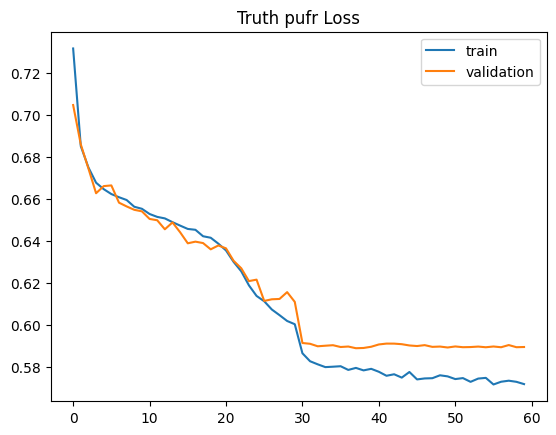


Training Baseline
Epoch: 1 	Train Loss: 0.7129 	Val Loss: 0.6941
Epoch: 2 	Train Loss: 0.686 	Val Loss: 0.6729
Epoch: 3 	Train Loss: 0.6715 	Val Loss: 0.6657
Epoch: 4 	Train Loss: 0.6653 	Val Loss: 0.6603
Epoch: 5 	Train Loss: 0.6637 	Val Loss: 0.6589
Epoch: 6 	Train Loss: 0.6615 	Val Loss: 0.6542
Epoch: 7 	Train Loss: 0.6589 	Val Loss: 0.6487
Epoch: 8 	Train Loss: 0.6587 	Val Loss: 0.6523
Epoch: 9 	Train Loss: 0.6568 	Val Loss: 0.6487
Epoch: 10 	Train Loss: 0.6556 	Val Loss: 0.6515
Epoch: 11 	Train Loss: 0.6549 	Val Loss: 0.6495
Epoch: 12 	Train Loss: 0.6535 	Val Loss: 0.6499
Epoch: 13 	Train Loss: 0.6537 	Val Loss: 0.6511
Epoch: 14 	Train Loss: 0.6516 	Val Loss: 0.6462
Epoch: 15 	Train Loss: 0.6525 	Val Loss: 0.6441
Epoch: 16 	Train Loss: 0.6489 	Val Loss: 0.642
Epoch: 17 	Train Loss: 0.6485 	Val Loss: 0.6428
Epoch: 18 	Train Loss: 0.6473 	Val Loss: 0.64
Epoch: 19 	Train Loss: 0.6452 	Val Loss: 0.6355
Epoch: 20 	Train Loss: 0.6423 	Val Loss: 0.6379
Epoch: 21 	Train Loss: 0.638 	Val 

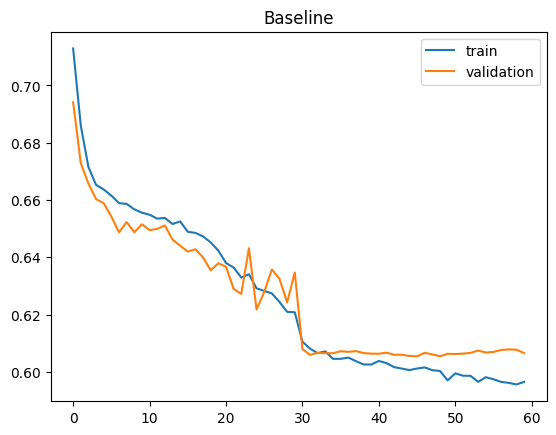

In [14]:
%%time
# Use BinaryCrossEntropy for binary classification
loss_fn = nn.BCELoss()

Epochs = 60

# Train model with pt,eta,phi,m,pufr
print("Training with Pred PUFR")
PUFR = Model2(5,32,1).to(device)
optimizer_pufr = optim.AdamW(PUFR.parameters(), lr=0.0001, weight_decay=0.01)
data = [X_train_pufr, y_train, X_val_pufr, y_val]
PUFR_history = train(PUFR, optimizer_pufr, data, epochs=Epochs)
plt.plot(PUFR_history['train_loss'],label='train')
plt.plot(PUFR_history['test_loss'],label='validation')
plt.title("Pred pufr Loss")
plt.legend()
plt.show()
print()

# Train model with pt,eta,phi,m,truth
print("Training with Truth")
Truth = Model2(5,32,1).to(device)
optimizer_truth = optim.AdamW(Truth.parameters(), lr=0.0001, weight_decay=0.01)
data = [X_train_truth, y_train, X_val_truth, y_val]
Truth_history = train(Truth, optimizer_truth, data, epochs=Epochs)
plt.plot(Truth_history['train_loss'],label='train')
plt.plot(Truth_history['test_loss'],label='validation')
plt.title("Truth pufr Loss")
plt.legend()
plt.show()
print()

# Train model with pt,eta,phi,m
print("Training Baseline")
Baseline = Model2(4,32,1).to(device)
optimizer_baseline = optim.AdamW(Baseline.parameters(), lr=0.0001, weight_decay=0.01)
data = [X_train_baseline, y_train, X_val_baseline, y_val]
Baseline_history = train(Baseline, optimizer_baseline, data, epochs=Epochs)
plt.plot(Baseline_history['train_loss'],label='train')
plt.plot(Baseline_history['test_loss'],label='validation')
plt.title("Baseline")
plt.legend()
plt.show()
print()

In [15]:
train_more=False
if train_more:
    Epochs = 30

    # Train model with pt,eta,phi,m,pufr
    print("Training with PUFR")
    data = [X_train_pufr, y_train, X_val_pufr, y_val]
    PUFR_history2 = train(PUFR, optimizer_pufr, data, epochs=Epochs)
    PUFR_history['train_loss'] = np.concatenate([PUFR_history['train_loss'],PUFR_history2['train_loss']], axis=0)
    PUFR_history['test_loss'] = np.concatenate([PUFR_history['test_loss'],PUFR_history2['test_loss']], axis=0)
    plt.plot(PUFR_history['train_loss'][2:],label='train')
    plt.plot(PUFR_history['test_loss'][2:],label='validation')
    plt.title("With pufr Loss")
    plt.legend()
    plt.show()

    # Train model with pt,eta,phi,m,pufr
    print("Training with Truth PUFR")
    data = [X_train_truth, y_train, X_val_truth, y_val]
    Truth_history2 = train(Truth, optimizer_truth, data, epochs=Epochs)
    Truth_history['train_loss'] = np.concatenate([Truth_history['train_loss'],Truth_history2['train_loss']], axis=0)
    Truth_history['test_loss'] = np.concatenate([Truth_history['test_loss'],Truth_history2['test_loss']], axis=0)
    plt.plot(Truth_history['train_loss'][2:],label='train')
    plt.plot(Truth_history['test_loss'][2:],label='validation')
    plt.title("With Truth pufr Loss")
    plt.legend()
    plt.show()

    print("Training Baseline")
    data = [X_train_baseline, y_train, X_val_baseline, y_val]
    Baseline_history2 = train(Baseline, optimizer_baseline, data, epochs=Epochs)
    Baseline_history['train_loss'] = np.concatenate([Baseline_history['train_loss'],Baseline_history2['train_loss']], axis=0)
    Baseline_history['test_loss'] = np.concatenate([Baseline_history['test_loss'],Baseline_history2['test_loss']], axis=0)
    plt.plot(Baseline_history['train_loss'][2:],label='train')
    plt.plot(Baseline_history['test_loss'][2:],label='validation')
    plt.title("Baseline")
    plt.legend()
    plt.show()

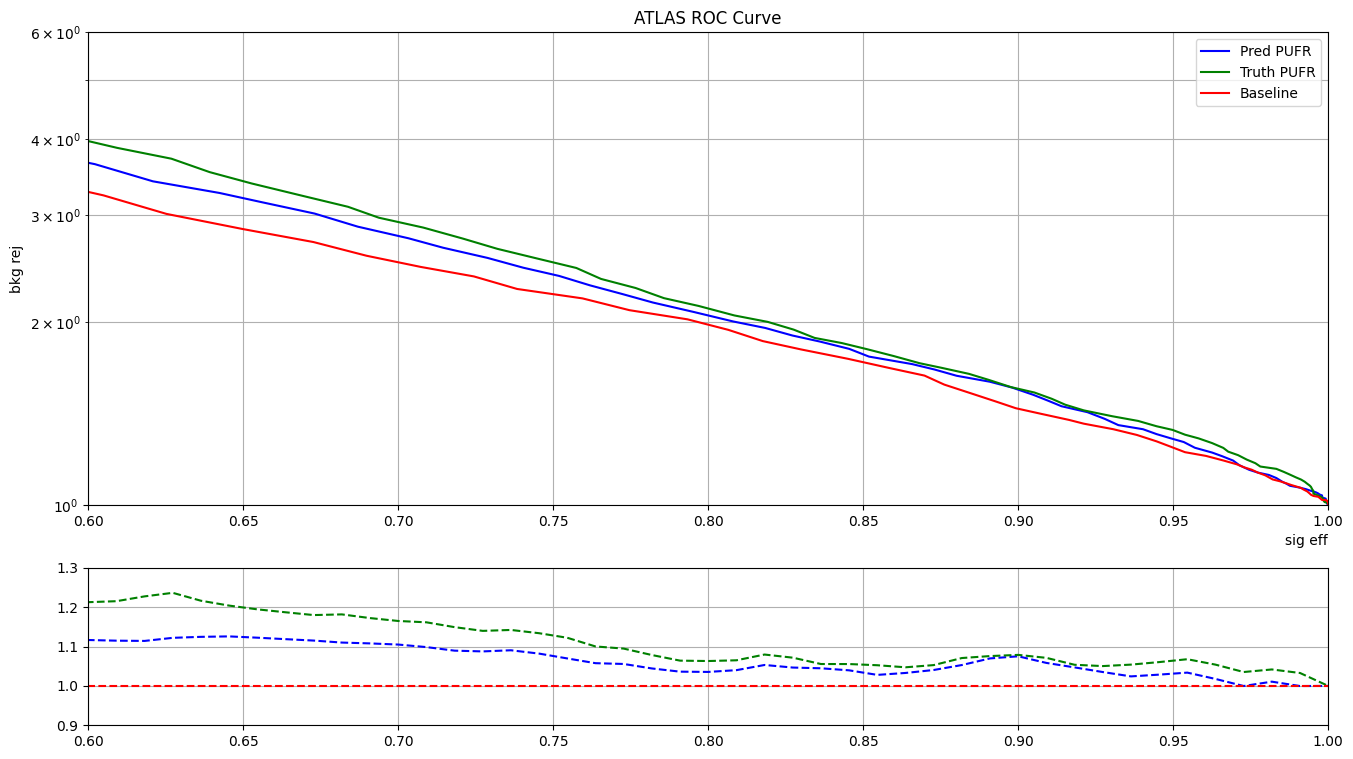

Pred PUFR	 Binary Accuracy:  0.6664 	F1 Score:  0.6936076414401176 	AUC:  0.7296670063532431

Truth PUFR	 Binary Accuracy:  0.6708 	F1 Score:  0.7001821493624772 	AUC:  0.7413036316383085

Baseline	 Binary Accuracy:  0.649 	F1 Score:  0.6787479406919276 	AUC:  0.7113441716231625



In [16]:
def ATLAS_roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig
    
    sig_eff = []
    bkg_eff = []
    
    thresholds = np.linspace(0,0.9,100)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        bkg_eff.append(1-((y_pred[bkg] < threshold).sum() / y_true[bkg].shape[0]))

        #print("Theshold: ", threshold)
        #print("Signal Efficiency: ", sig_eff[-1])
        #print("Background Efficiency: ", bkg_eff[-1],"\n")
        
    bkg_rej = [1/x for x in bkg_eff]
    return np.array(sig_eff), np.array(bkg_rej), thresholds

def get_predictions(model, data):
    X_test = data
    model.to(device)
    model.eval()
    
    label_pred = []

    num_test = X_test.size(0)
    for event in range(num_test):
        l_pred = model(X_test[event].to(device))
        label_pred.append(l_pred.detach().cpu().numpy())
    label_pred = np.array(label_pred)
    return label_pred

def get_metrics(y_true, y_pred, threshold):
    y_Pred = y_pred > threshold
    x,y, thresholds = ATLAS_roc(y_true, y_pred)
    AUC = roc_auc_score(y_true, y_pred)
    BA = accuracy_score(y_true, y_Pred)
    f1 = f1_score(y_true, y_Pred)
    return x,y,thresholds,AUC,BA,f1

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [3, 1]})

pufr_pred = get_predictions(PUFR, X_test_pufr)
truth_pred = get_predictions(Truth, X_test_truth)
baseline_pred = get_predictions(Baseline, X_test_baseline)

x1,y1,th1,AUC1,BA1,f11 = get_metrics(y_test, pufr_pred, 0.5)
x2,y2,th2,AUC2,BA2,f12 = get_metrics(y_test, truth_pred, 0.5)
x3,y3,th3,AUC3,BA3,f13 = get_metrics(y_test, baseline_pred, 0.5)

ax1.set_title("ATLAS ROC Curve")
ax1.set_xlabel("sig eff",loc='right')
ax1.set_ylabel("bkg rej")

ax1.plot(x1,y1, label="Pred PUFR",color='b')
#AUC = "All Jets ROC AUC: " + str(round(AUC1,4))

ax1.plot(x2,y2, label="Truth PUFR",color='g')
#AUC = "All Jets ROC AUC: " + str(round(AUC1,4))
#ax1.text(0.71,8,AUC)

ax1.plot(x3,y3, label="Baseline",color='r')
#AUC = "Leading ROC AUC: " + str(round(AUC2,4))
#ax1.text(0.71,4,AUC)

# Plot ratio plot
x = 1-np.flip(th3)
ratio1 = np.interp(x,np.flip(x1),np.flip(y1))/np.interp(x,np.flip(x3),np.flip(y3))
ratio2 = np.interp(x,np.flip(x2),np.flip(y2))/np.interp(x,np.flip(x3),np.flip(y3))
ratio3 = np.interp(x,np.flip(x3),np.flip(y3))/np.interp(x,np.flip(x3),np.flip(y3))

ax2.plot(x,ratio1,linestyle='--',color='b')
ax2.plot(x,ratio2,linestyle='--',color='g')
ax2.plot(x,ratio3,linestyle='--',color='r')

# General Plot Settings
ax1.legend()
ax1.set_yscale('log')
ax1.grid(which='both')
ax2.grid(which='both')
ax1.set_ylim(1,6)
ax1.set_xlim(0.6,1)
ax2.set_xlim(0.6,1)
ax2.set_ylim(0.9,1.3)
plt.show()

print("Pred PUFR\t","Binary Accuracy: ", BA1, "\tF1 Score: ", f11, "\tAUC: ", AUC1)
print("")
print("Truth PUFR\t","Binary Accuracy: ", BA2, "\tF1 Score: ", f12, "\tAUC: ", AUC2)
print("")
print("Baseline\t","Binary Accuracy: ", BA3, "\tF1 Score: ", f13, "\tAUC: ", AUC3)
print("")

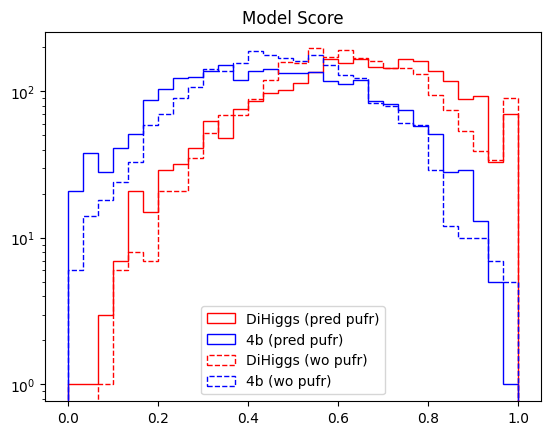

In [17]:
mask = y_test==1

plt.title("Model Score")

plt.hist(pufr_pred[mask],color='r',histtype='step',label='DiHiggs (pred pufr)',bins=30,range=(0,1))
plt.hist(pufr_pred[~mask],color='b',histtype='step',label='4b (pred pufr)',bins=30,range=(0,1))

#plt.hist(truth_pred[mask],color='k',histtype='step',label='DiHiggs (truth pufr)',bins=30,range=(0,1))
#plt.hist(truth_pred[~mask],color='k',histtype='step',label='4b (truth pufr)',bins=30,linestyle='--',range=(0,1))

plt.hist(baseline_pred[mask],color='r',histtype='step',label='DiHiggs (wo pufr)',bins=30,range=(0,1),linestyle='--')
plt.hist(baseline_pred[~mask],color='b',histtype='step',label='4b (wo pufr)',bins=30,range=(0,1),linestyle='--')

plt.yscale('log')
plt.legend()
plt.show()